In [0]:
!pip install --upgrade -q -I scs
!pip install --upgrade -q cvxpy

# Exact Recovery in the Stochastic Block Model

**Authors:** Haaris Khan, Antares Chen

Let's code the semidefinite programming algorithm for exactly recovering the partitions in a stochastic block model. Before we begin, let's setup our notebook.

In [0]:
from networkx.generators.community import planted_partition_graph
from cvxpy import Maximize, Variable, trace, Problem

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

## The Algorithm

We wrap the algorithm in the class StochasticBlockModel. Some nice things to note:

- The CVXPY package is a well-supported package for solving optimization problems in Python. We use this to solve our SDP.
- The NetworkX package implements various tooling for manipulating graphs in Python. In particular, they have conveniently implemented a planted-partition graph generator.
- We use numpy to implement the top eigenvector rounding and various visualizations of the graph. 

Let's take a look at the code.

In [0]:
class StochasticBlockModel():
    """ A class to recover the parititions in a Stochastic Block Model. """

    def __init__(self, n, p, q):
        self.num_groups = 2
        self.n = n
        self.p = p
        self.q = q
        self.graph = planted_partition_graph(self.num_groups, self.n // 2, self.p, self.q)
        self.adj = nx.to_numpy_matrix(self.graph)
        self.J = np.ones((self.n, self.n))
        self.a, self.b = self.n * self.p / 2, self.n * self.q / 2
        
    def visualize(self, node_color='r'):
        """ Visualize the current model's graph. """
        plt.figure(figsize=(15, 12))
        nx.draw_networkx(self.graph, node_color=node_color, width=0.5)

    def is_recoverable(self):
        """ Returns true if the parititon is recoverable.
        
        Recall that the partition is recoverable if the expected in-community 
        degree is greater than the expected cross-community degree by a factor 
        of O(sqrt(n)).
        """
        return (self.a - self.b) > 2 * np.sqrt(np.log(self.n)) * np.sqrt(self.a + self.b)

    def find_partition(self):
        """ Creates and solves the SDP for finding the partitions.
        
        The program takes the form:
        
        maximize_X <A, X>
        subject to X_ii = 1 for all i in V
                   <J, X> = 0
                   X >> 0
        """
        if not self.is_recoverable():
            raise Exception("a - b is not sufficiently large")

        # Create the variable and add the objective.
        X = Variable((self.n, self.n), PSD=True)
        objective = Maximize(trace(self.adj * X))
        
        # Add the constraints
        constraints = []
        for i in range(self.n):
            constraints.append(X[i, i] == 1)
        constraints.append(trace(self.J * X) == 0)
        
        # Solve the program
        problem = Problem(objective, constraints)
        problem.solve()
        return problem

    def get_cut(self, X):
        """ Recovers the two partitions from the solution of the SDP X. """
        # Get the spectrum of X
        eigenvalues, eigenvectors = np.linalg.eig(X)

        # Split the top eigenvector element-wise based on its sign
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:,idx]
        largest = eigenvectors[:, 0]
        return largest

## Running the Code

Let's try to see what happens when we create a Stochastic Block Model with `p=0.9` and `q=0.1`.

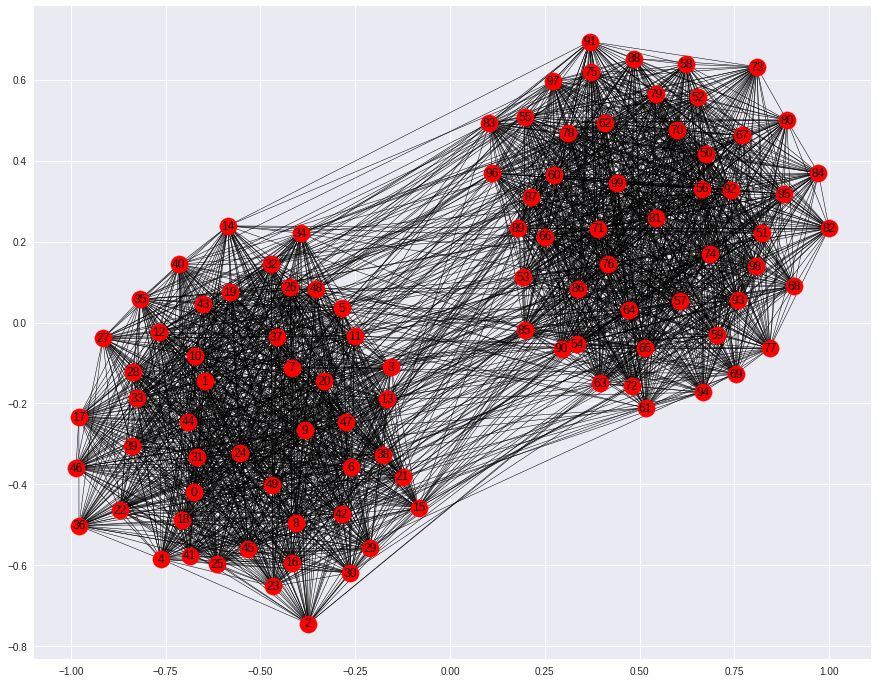

In [43]:
sbm = StochasticBlockModel(100, .9, .1)
sbm.visualize()

We can see the two communities, but how does the exact recovery algorithm fair?

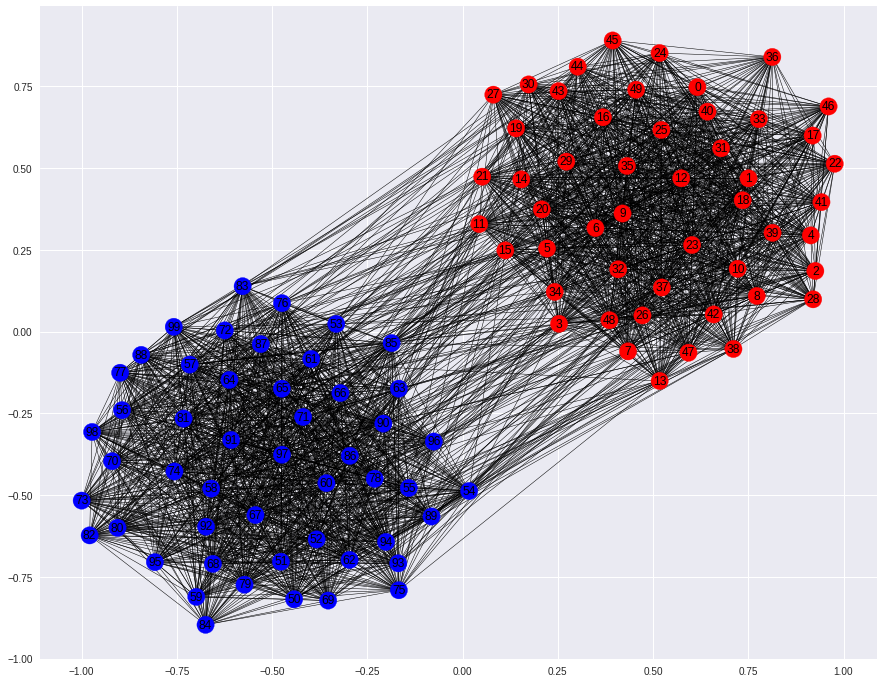

In [45]:
# Recover the partitions
soln = sbm.find_partition()
X = soln.variables()[0].value
indicator = sbm.get_cut(X)

# Create the cut vector that will color the two communities different colors
cut = ['red' if i >= 0 else 'blue' for i in indicator]

# Visualize the graph
sbm.visualize(node_color=cut)

Looks like we're in good shape!